# 0. Objective
- The **TASK 1** is to predict the store-wide and categorical/departmental-wise sales for each store for weeks in the future.
- The **TASK 2** is to evaluate the effect of the 5 markdowns and/or CPI, temperatures, etc. on sales preceding the major holidays.
- 
<div style="text-align: center;">
    <img src="holiday_dates.jpg" alt="Holiday Dates">
</div>

# 1. Module Management, Data and auxiliary data import

- The first four CSV files are from the Kaggle competition [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data). The last CSV file is from the Walmart website [Walmart Departments](https://www.kaggle.com/manjeetsingh/retaildataset). 

- The 5th CSV file is a dataset that contains the department names and their respective department numbers we used NLP tools to extract the department names, the department numbers, the In-Full Category, and the Merch Align from [this source](https://5407613.fs1.hubspotusercontent-na1.net/hubfs/5407613/SW%20-%20Ebooks%20%2B%20Resources/%5BOFFICIAL%5DWalmartDepartments%2cCategories%2candFinelines-Final%20(1).pdf). We can use this piece of information to understand the department names and their respective department numbers, then cluster departments sharing the same In-Full Category and Merch Align together to get better insights and predictions about the sales data.
<div style="text-align: center;">
    <img src="dept.png" alt="Holiday Dates">
</div>

- (optional) The 6th CSV file is a dataset that contains the mapping between the 45 store numbers and their corresponding 20 weather stations that comes from another Kaggle competition [Walmart Recruiting II: Sales in Stormy Weather](https://www.kaggle.com/competitions/walmart-recruiting-sales-in-stormy-weather/data), who also works on the data of 45 Walmart stores from 2012 to 2014. If we can put our faith in the assumption that the 45 stores are identical between those 2 datasets, we can use this piece of information to cluster stores sharing the same weather stations together for geological adjacency to further reduce the cemplexity of our models to build and get better insights and predictions about the sales data.
  

In [1]:
## Library
# Data handling
import pandas as pd
import numpy as np


# Viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

# ML
from sklearn import model_selection, metrics
from statsmodels.tsa.seasonal import STL, seasonal_decompose

In [2]:
# Aesthetics
sns.set_style("ticks")
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 12
pd.options.display.max_columns = None
pd.options.display.max_rows = 20

In [3]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
walmart_dept = pd.read_csv('walmart-departments.csv')
walmart_weather_station = pd.read_csv('key.csv')

## 1.1 Table descriptions: features
- Store - the store number, 1-45
- Date - the week from 2010-02-05 to 2013-07-26, but we only have sales data from 2010-02-05 to 2012-10-26. That means we only have sales data for 143 weeks to train our model and validate it.
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA. (This is a key field for the competition.) Most likely the missing values are due to no promotions running that week.
- CPI - the consumer price index. NA values are only for weeks on and after 2013-05-03, which are outside the scope of our model training. Just drop those weeks for now.
- Unemployment - the unemployment rate. NA values are only for weeks on and after 2013-05-03, which are outside the scope of our model training. Just drop those weeks for now.
- IsHoliday - whether the week is a special holiday week. 

In [4]:
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## 1.2 Table descriptions: stores
- Store - the store number, 1-45
- Type - the store type. The type of store is indicated by a letter A, B, or C.
- Size - the store size in square feet


In [5]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## 1.3 Table descriptions: train
- Store - the store number, 1-45
- Dept - the department number

In [6]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## 1.4 Table descriptions: test
This file is identical to train.csv, except we have withheld the weekly sales from the week 2012-11-02 to 2013-07-26. So, basically, we have to predict the sales for each triplet of store, department, and date in this file.

## 1.5 Table descriptions: walmart_dept 
- Accounting Department - the department number, 1-99, but only 81 are present in the original dataset, and 87 are present in the walmart_dept dataset. And department 48 does not have its corresponding department name in the walmart_dept dataset.
- From [this source](https://technomantic.com/walmart-department-numbers/), we find that Department 48 is the "Firearms" department, which is not present in the walmart_dept dataset. It can be substituted with the "Sporting Goods" department, which is the "General Merchandise" In Full Category and "Hardlines" Merch Align.
- Department Name - the department name corresponding to the department number. Some department codes share the SAME department name, but they have different In-Full Category and Merch Align. We find that the department names are not unique, and some department names are not present in the original dataset. We will substitute the department names that are not present in the original dataset with the department numbers that have the same department names in the original dataset. After this step, we will have 71 departments in the walmart_dept dataset.
- In-Full Category - the category of the department, which is a high level of grouping of the departments. There are FIVE categories:
    - 'Consumables' with 8 departments,
    - 'Food' with 14 departments,
    - 'General Merchandise' with 52 departments,
    - 'Health and Wellness' with 5 departments,
    -  8 departments that are not originally labeled but assigned as 'Service' after reviewing the document details.  
- Merch Align - the merchandise alignment of the department, which is like a sub-category of the departments based on the properties of merchandises within the departments. There are 8 sub-categories:
    - 'Apparel' with 18 departments,
    - 'Consumables' with 7 departments, 
    - 'Entertainment, Toys, and Seasonal' with 10 departments,
    - 'Food' with 14 departments,
    - 'Hardlines' with 15 departments,
    - 'Health and Wellness' with 5 departments,
    - 'Home' with 10 departments,
    - 'Service' with 9 departments.

In [7]:
# find the department number that is present in the train dataset
np.sort(train['Dept'].unique())
# 81 unique values
# train['Dept'] misses 7 departments compared to walmart_dept['Accounting Department']
# missing 15 Health and Wellness
# missing 53 Stationery, which is substituted to 03 Stationery
# missing 57 Hearing Center
# missing 73 Stationery, which is substituted to 03 Stationery
# missing 86 Financial Services Walmart Services
# missing 88 PMDC Signage
# missing 89 Everyday Services Walmart Travel

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
       83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64)

In [8]:
# add Department 48 is the "Firearms" department, which is not present in the walmart_dept dataset. It can be substituted with the "Sporting Goods" department, which is the "General Merchandise" In Full Category and "Hardlines" Merch Align.
new_row = {'Accounting Department': 48, 'Department Name': 'Firearms', 'In Full Category': 'General Merchandise', 'Merch Align': 'Hardlines'}
walmart_dept = pd.concat([walmart_dept, pd.DataFrame([new_row])], ignore_index=True)

In [9]:
# find the department that can be substituted with the same department name in the dataset
walmart_dept['Department Name'].value_counts(dropna=False).head(15)

Department Name
Stationery                            3
Piece Goods Fabrics and Crafts        3
Jewelry                               3
Sporting Goods                        3
Cosmetics Fragrances and Skin Care    2
Auto Service                          2
Mens Wear                             2
Optical                               2
Ladies Wear                           2
Deli                                  2
Automotive                            2
Toys                                  2
Media and Gaming                      2
Concept Stores                        1
Commerical Bread                      1
Name: count, dtype: int64

In [10]:
# Replace the department with name 'Stationery' with the department number 03, which is the main 'Stationery' department
dept_stationary = walmart_dept.loc[walmart_dept['Department Name'] == 'Stationery', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_stationary), 'Accounting Department'] = 3
# Replace the department with name 'Piece Goods Fabrics and Crafts' with the department number 19, which is the main 'Piece Goods Fabrics and Crafts' department
dept_piece_goods = walmart_dept.loc[walmart_dept['Department Name'] == 'Piece Goods Fabrics and Crafts', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_piece_goods), 'Accounting Department'] = 19
# Replace the department with name 'Jewelry' with the department number 32, which is the main 'Jewelry' department
dept_jewelry = walmart_dept.loc[walmart_dept['Department Name'] == 'Jewelry', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_jewelry), 'Accounting Department'] = 32
# Replace the department with name 'Sporting Goods' with the department number 09, which is the main 'Sporting Goods' department
dept_sporting_goods = walmart_dept.loc[walmart_dept['Department Name'] == 'Sporting Goods', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_sporting_goods), 'Accounting Department'] = 9
# Replace the department with name 'Cosmetics Fragrances and Skin Care' with the department number 46, which is the main 'Cosmetics Fragrances and Skin Care' department
dept_cosmetics = walmart_dept.loc[walmart_dept['Department Name'] == 'Cosmetics Fragrances and Skin Care', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_cosmetics), 'Accounting Department'] = 46
# Replace the department with name 'Auto Service' with the department number 37, which is the main 'Auto Service' department
dept_auto_service = walmart_dept.loc[walmart_dept['Department Name'] == 'Auto Service', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_auto_service), 'Accounting Department'] = 37
# Replace the department with name 'Mens Wear' with the department number 23, which is the main 'Mens Wear' department
dept_mens_wear = walmart_dept.loc[walmart_dept['Department Name'] == 'Mens Wear', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_mens_wear), 'Accounting Department'] = 23
# Replace the department with name 'Optical' with the department number 49, which is the main 'Optical' department
dept_optical = walmart_dept.loc[walmart_dept['Department Name'] == 'Optical', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_optical), 'Accounting Department'] = 49
# Replace the department with name 'Ladies Wear' with the department number 34, which is the main 'Ladies Wear' department
dept_ladies_wear = walmart_dept.loc[walmart_dept['Department Name'] == 'Ladies Wear', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_ladies_wear), 'Accounting Department'] = 34
# Replace the department with name 'Deli' with the department number 80, which is the main 'Deli' department
dept_deli = walmart_dept.loc[walmart_dept['Department Name'] == 'Deli', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_deli), 'Accounting Department'] = 80
# Replace the department with name 'Automotive' with the department number 10, which is the main 'Automotive' department
dept_automotive = walmart_dept.loc[walmart_dept['Department Name'] == 'Automotive', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_automotive), 'Accounting Department'] = 10
# Replace the department with name 'Toys' with the department number 7, which is the main 'Toys' department
dept_toys = walmart_dept.loc[walmart_dept['Department Name'] == 'Toys', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_toys), 'Accounting Department'] = 7
# Replace the department with name 'Media and Gaming' with the department number 5, which is the main 'Media and Gaming' department
dept_media_gaming = walmart_dept.loc[walmart_dept['Department Name'] == 'Media and Gaming', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_media_gaming), 'Accounting Department'] = 5

In [11]:
# find the unique Accounting Department, In-Full Category and Merch Align in the dataset
n_dept = np.unique(walmart_dept['Accounting Department'],return_counts=True)
n_dept_name = np.unique(walmart_dept['Department Name'],return_counts=True)
n_category = np.unique(walmart_dept['In Full Category'],return_counts=True)
n_merch = np.unique(walmart_dept['Merch Align'],return_counts=True)
print(f"There are {len(n_dept[0])} unique departments in the dataset.")
print(f"There are {len(n_category[0])} unique categories in the dataset.")
print(f"There are {len(n_merch[0])} unique merch alignments in the dataset.")

There are 71 unique departments in the dataset.
There are 5 unique categories in the dataset.
There are 8 unique merch alignments in the dataset.


In [12]:
walmart_dept.groupby(['In Full Category','Merch Align'])[['Accounting Department','Department Name']].agg(lambda x: set(x.tolist())).reset_index()

,In Full Category,Merch Align,Accounting Department,Department Name
0,Consumables,Apparel,{79},{Infant Consumable Hardlines}
1,Consumables,Consumables,"{2, 4, 8, 40, 13, 46}","{OTC Pharmacy , Personal Care Health and Beaut..."
2,Food,Food,"{96, 1, 98, 80, 81, 82, 83, 90, 91, 92, 93, 94...","{Seafood, Grocery Dry Goods, DSD Grocery and S..."
3,General Merchandise,Apparel,"{32, 33, 34, 35, 36, 23, 24, 25, 26, 27, 28, 2...","{Mens Wear, Jewelry, Girls Wear, Boys Wear, La..."
4,General Merchandise,"Entertainment, Toys, and Seasonal","{67, 5, 6, 7, 72, 18, 21, 87}","{Celebration and Cards, Wireless, Electronics,..."
5,General Merchandise,Hardlines,"{3, 99, 9, 10, 11, 12, 77, 16, 48, 56}","{Automotive, Large Appliances, Firearms, Hardw..."
6,General Merchandise,Home,"{71, 74, 14, 17, 19, 20, 22}","{Bath and Shower, Furniture, Bedding, Kitchen ..."
7,Health and Wellness,Health and Wellness,"{49, 57, 38, 15}","{Hearing Center, Optical, Clinics, Health and ..."
8,Service,Service,"{37, 39, 85, 86, 88, 89, 58, 60}","{Financial Services Walmart Services, Everyday..."


In [13]:
# drop the duplicates in the walmart_dept table
pd.options.display.max_rows = 75
walmart_dept = walmart_dept.drop_duplicates().reset_index(drop=True)
walmart_dept.sort_values(by='Accounting Department').reset_index(drop=True)

,Department Name,Accounting Department,In Full Category,Merch Align
0,Candy and Tobacco,1,Food,Food
1,Personal Care Health and Beauty Aids,2,Consumables,Consumables
2,Stationery,3,General Merchandise,Hardlines
3,Paper Goods Household Paper,4,Consumables,Consumables
4,Media and Gaming,5,General Merchandise,"Entertainment, Toys, and Seasonal"
5,Wireless Wearables Cameras and Supplies,6,General Merchandise,"Entertainment, Toys, and Seasonal"
6,Toys,7,General Merchandise,"Entertainment, Toys, and Seasonal"
7,Pets and Supplies,8,Consumables,Consumables
8,Sporting Goods,9,General Merchandise,Hardlines
9,Automotive,10,General Merchandise,Hardlines


## 1.6 Table descriptions: walmart_weather_station (optional)
- Store - the store number, 1-45
- Station - the weather station number, 1-20

In [14]:
walmart_weather_station.info()
walmart_weather_station.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   store_nbr    45 non-null     int64
 1   station_nbr  45 non-null     int64
dtypes: int64(2)
memory usage: 848.0 bytes


,store_nbr,station_nbr
0,1,1
1,2,14
2,3,7
3,4,9
4,5,12


# 2. Data preprocessing 

 ## 2.1 Replace the as-is department number with the department number post substitution in the train table per the walmart_dept table
 
- We first add a new column 'New_Dept' to the train table, which is the same as the 'Dept' column.
- Then, we replace the department['New_Dept'] with the number 03, which is the main 'Stationery' department, if the department number is in the dept_stationary list.
- Then, we replace the department['New_Dept'] with the number 19, which is the main 'Piece Goods Fabrics and Crafts' department, if the department number is in the dept_piece_goods list.
- Then, we replace the department['New_Dept'] with the number 32, which is the main 'Jewelry' department, if the department number is in the dept_jewelry list.
- Then, we replace the department['New_Dept'] with the number 09, which is the main 'Sporting Goods' department, if the department number is in the dept_sporting_goods list.
- Then, we replace the department['New_Dept'] with the number 46, which is the main 'Cosmetics Fragrances and Skin Care' department, if the department number is in the dept_cosmetics list.
- Then, we replace the department['New_Dept'] with the number 37, which is the main 'Auto Service' department, if the department number is in the dept_auto_service list.
- Then, we replace the department['New_Dept'] with the number 23, which is the main 'Mens Wear' department, if the department number is in the dept_mens_wear list.
- Then, we replace the department['New_Dept'] with the number 49, which is the main 'Optical' department, if the department number is in the dept_optical list.
- Then, we replace the department['New_Dept'] with the number 34, which is the main 'Ladies Wear' department, if the department number is in the dept_ladies_wear list.
- Then, we replace the department['New_Dept'] with the number 80, which is the main 'Deli' department, if the department number is in the dept_deli list.
- Then, we replace the department['New_Dept'] with the number 10, which is the main 'Automotive' department, if the department number is in the dept_automotive list.
- Then, we replace the department['New_Dept'] with the number 7, which is the main 'Toys' department, if the department number is in the dept_toys list.
- Then, we replace the department['New_Dept'] with the number 5, which is the main 'Media and Gaming' department, if the department number is in the dept_media_gaming list.
- As a result, we will have 66 unique departments in the train table. This is because departments contained in walmart_dept [15, 57, 86, 88, 89], or ['Clinics, Health and Wellness', 'Hearing Center', 'Financial Services Walmart Services', 'PMDC Signage', 'Everyday Services Walmart Travel
'] never occur in the train table.
- Next, we drop the 'Dept' column from the train table and keep the 'New_Dept' column as the department number.
- Eventually, we need to sum up the weekly sales for each store-new_dept pair in the train table, since the train table contains multiple rows for the same store-new_dept pair in the same week due to the above operations. The final table is re-named as train1.


In [15]:
train['New_Dept'] = train['Dept']
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,New_Dept
0,1,1,2010-02-05,24924.50,False,1
1,1,1,2010-02-12,46039.49,True,1
2,1,1,2010-02-19,41595.55,False,1
3,1,1,2010-02-26,19403.54,False,1
4,1,1,2010-03-05,21827.90,False,1


In [16]:
# replace the department['New_Dept'] with the number 03, which is the main 'Stationery' department, if the department number is in the dept_stationary list
train.loc[train['New_Dept'].isin(dept_stationary), 'New_Dept'] = 3
# replace the department['New_Dept'] with the number 19, which is the main 'Piece Goods Fabrics and Crafts' department, if the department number is in the dept_piece_goods list
train.loc[train['New_Dept'].isin(dept_piece_goods), 'New_Dept'] = 19
# replace the department['New_Dept'] with the number 32, which is the main 'Jewelry' department, if the department number is in the dept_jewelry list
train.loc[train['New_Dept'].isin(dept_jewelry), 'New_Dept'] = 32
# replace the department['New_Dept'] with the number 09, which is the main 'Sporting Goods' department, if the department number is in the dept_sporting_goods list
train.loc[train['New_Dept'].isin(dept_sporting_goods), 'New_Dept'] = 9
# replace the department['New_Dept'] with the number 46, which is the main 'Cosmetics Fragrances and Skin Care' department, if the department number is in the dept_cosmetics list
train.loc[train['New_Dept'].isin(dept_cosmetics), 'New_Dept'] = 46
# replace the department['New_Dept'] with the number 37, which is the main 'Auto Service' department, if the department number is in the dept_auto_service list
train.loc[train['New_Dept'].isin(dept_auto_service), 'New_Dept'] = 37
# replace the department['New_Dept'] with the number 23, which is the main 'Mens Wear' department, if the department number is in the dept_mens_wear list
train.loc[train['New_Dept'].isin(dept_mens_wear), 'New_Dept'] = 23
# replace the department['New_Dept'] with the number 49, which is the main 'Optical' department, if the department number is in the dept_optical list
train.loc[train['New_Dept'].isin(dept_optical), 'New_Dept'] = 49
# replace the department['New_Dept'] with the number 34, which is the main 'Ladies Wear' department, if the department number is in the dept_ladies_wear list
train.loc[train['New_Dept'].isin(dept_ladies_wear), 'New_Dept'] = 34
# replace the department['New_Dept'] with the number 80, which is the main 'Deli' department, if the department number is in the dept_deli list
train.loc[train['New_Dept'].isin(dept_deli), 'New_Dept'] = 80
# replace the department['New_Dept'] with the number 10, which is the main 'Automotive' department, if the department number is in the dept_automotive list
train.loc[train['New_Dept'].isin(dept_automotive), 'New_Dept'] = 10
# replace the department['New_Dept'] with the number 7, which is the main 'Toys' department, if the department number is in the dept_toys list
train.loc[train['New_Dept'].isin(dept_toys), 'New_Dept'] = 7
# replace the department['New_Dept'] with the number 5, which is the main 'Media and Gaming' department, if the department number is in the dept_media_gaming list
train.loc[train['New_Dept'].isin(dept_media_gaming), 'New_Dept'] = 5

In [17]:
# find the set difference between the department number in the train table and the department number in the walmart_dept table
np.setdiff1d( np.sort(walmart_dept['Accounting Department'].unique()),np.sort(train['New_Dept'].unique()))

array([15, 57, 86, 88, 89], dtype=int64)

In [18]:
# drop the 'Dept' column from the train table and keep the 'New_Dept' column as the department number
train = train.drop(columns='Dept')

In [19]:
# sum up the weekly sales for each store-new_dept pair in the train table
a = train[['Store','New_Dept','Date','Weekly_Sales']].groupby(['Store','New_Dept','Date']).agg({'Weekly_Sales':'sum'}).reset_index()
# merge a with features['IsHoliday'] to get the 'IsHoliday' column back to the train table as train1 now
train1 = a.merge(features[['Store','Date','IsHoliday']], on = ["Store","Date"], how="left")

In [20]:
train1.info()
train1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372039 entries, 0 to 372038
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         372039 non-null  int64  
 1   New_Dept      372039 non-null  int64  
 2   Date          372039 non-null  object 
 3   Weekly_Sales  372039 non-null  float64
 4   IsHoliday     372039 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 11.7+ MB


,Store,New_Dept,Weekly_Sales
count,372039.000000,372039.000000,372039.000000
mean,22.336752,42.598553,18108.905215
std,12.847587,31.625950,23998.785861
min,1.000000,1.000000,-4988.940000
25%,11.000000,16.000000,2858.000000
50%,22.000000,32.000000,9235.420000
75%,33.000000,74.000000,24031.255000
max,45.000000,99.000000,693099.360000


## 2.2 Merge the features and stores tables

- Given the fact that not all stores possess the same set of departments, we will first enumerate all store-department pairs for each store. 
- Then, left join with the walmart_dept table to get the department name, In-Full Category, and Merch Align information for each store-department pair.
- It is ensued by left joining with the stores table to get the store type and size information for each store-department pair. Up to this step, we have a 2,821 by 7 table, which covers all the possible store-department pairs and their corresponding department name, In-Full Category, Merch Align, store type, and size information.
- Next, we right join with the features table to get all the features at all weeks during the selected time period for each store-department pair, even though this span causes some missing values for 513,422 store-dept pairs' weekly sales. We will handle this during missing data imputation later. 
- Eventually, we left join with the train table to get the weekly sales for each store-department pair. Remember to drop the duplicate 'isHoliday' column from the train table, since it is already in the features table.
- As the final touch, we drop the weeks greater than the max date in the train data, since we don't have sales data for those weeks. At last, the joined dataframe is a 403,403 entries by 19 columns table.


In [21]:
pd.options.display.max_rows = 15
# find the New_dept for each store in a via groupby and agg f
store_dept = train1[['Store','New_Dept']].drop_duplicates().groupby('Store').agg({'New_Dept':lambda x: x.tolist()}).reset_index()
# find the number of unique New_Dept for each store
store_dept['num_dept'] = store_dept['New_Dept'].apply(lambda x: len(x))
store_dept

,Store,New_Dept,num_dept
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",65
1,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",66
2,3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",60
3,4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",66
4,5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",60
...,...,...,...
40,41,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",65
41,42,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",56
42,43,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",56
43,44,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",57


In [22]:
# Get all the combination between Store and its available Dept
df = train1[['Store','New_Dept']].drop_duplicates()
# Left join all the available store-dept pair with walmart_dept to get corresponding the department name, In-Full Category, and Merch Align
df = df.merge(walmart_dept, left_on='New_Dept', right_on='Accounting Department', how='left').drop(columns='Accounting Department')
# Left join with stores table to get the store type and size
df = df.merge(stores, on='Store', how='left')
# re-arrange the columns as store related columns first, then dept related columns
df = df[['Store','Type','Size','New_Dept','Department Name','In Full Category','Merch Align']]
df.head()

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align
0,1,A,151315,1,Candy and Tobacco,Food,Food
1,1,A,151315,2,Personal Care Health and Beauty Aids,Consumables,Consumables
2,1,A,151315,3,Stationery,General Merchandise,Hardlines
3,1,A,151315,4,Paper Goods Household Paper,Consumables,Consumables
4,1,A,151315,5,Media and Gaming,General Merchandise,"Entertainment, Toys, and Seasonal"


In [23]:
# right join current df with features, so that for every store-dept pair, we have all the features at all weeks during the time period, even though this span causes some weeks' sales data are missing for this store-dept pair. 
df = df.merge(features, on = ["Store"], how="right")
df.head()

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,A,151315,1,Candy and Tobacco,Food,Food,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,A,151315,2,Personal Care Health and Beauty Aids,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,A,151315,3,Stationery,General Merchandise,Hardlines,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,A,151315,4,Paper Goods Household Paper,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,A,151315,5,Media and Gaming,General Merchandise,"Entertainment, Toys, and Seasonal",2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


In [24]:
# left join df with train1 to get the weekly sales, and drop the duplicate 'isHoliday' column from the train table, since it is already in the features table
df = df.merge(train1.drop(columns='IsHoliday'), on = ["Store","New_Dept","Date"], how="left")
df.head()

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,A,151315,1,Candy and Tobacco,Food,Food,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,A,151315,2,Personal Care Health and Beauty Aids,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27
2,1,A,151315,3,Stationery,General Merchandise,Hardlines,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12
3,1,A,151315,4,Paper Goods Household Paper,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04
4,1,A,151315,5,Media and Gaming,General Merchandise,"Entertainment, Toys, and Seasonal",2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,53478.69


In [25]:
# drop weeks greater than max date in train1 data, since we don't have sales data for those weeks
max_date = np.max(train1.Date)
df= df[df["Date"]<=max_date].reset_index(drop=True)
df.head()

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,A,151315,1,Candy and Tobacco,Food,Food,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,A,151315,2,Personal Care Health and Beauty Aids,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27
2,1,A,151315,3,Stationery,General Merchandise,Hardlines,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12
3,1,A,151315,4,Paper Goods Household Paper,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04
4,1,A,151315,5,Media and Gaming,General Merchandise,"Entertainment, Toys, and Seasonal",2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,53478.69


In [26]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403403 entries, 0 to 403402
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Store             403403 non-null  int64  
 1   Type              403403 non-null  object 
 2   Size              403403 non-null  int64  
 3   New_Dept          403403 non-null  int64  
 4   Department Name   403403 non-null  object 
 5   In Full Category  403403 non-null  object 
 6   Merch Align       403403 non-null  object 
 7   Date              403403 non-null  object 
 8   Temperature       403403 non-null  float64
 9   Fuel_Price        403403 non-null  float64
 10  MarkDown1         143023 non-null  float64
 11  MarkDown2         103819 non-null  float64
 12  MarkDown3         128932 non-null  float64
 13  MarkDown4         125105 non-null  float64
 14  MarkDown5         143871 non-null  float64
 15  CPI               403403 non-null  float64
 16  Unemployment      40

,Store,Size,New_Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
count,403403.000000,403403.000000,403403.000000,403403.000000,403403.000000,143023.000000,103819.000000,128932.000000,125105.000000,143871.000000,403403.000000,403403.000000,372039.000000
mean,22.698688,132753.277916,43.895073,60.444751,3.358875,7006.073486,3260.204901,1375.615501,3334.907848,4505.523154,171.372601,7.984290,18108.905215
std,12.901627,62382.264108,31.758996,18.453335,0.458907,8220.094958,9338.363592,9382.720725,6239.756729,5888.463333,39.275884,1.870396,23998.785861
min,1.000000,34875.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,-4988.940000
25%,12.000000,93188.000000,17.000000,47.170000,2.932000,1905.340000,38.810000,4.860000,493.580000,1767.580000,131.863129,6.891000,2858.000000
50%,23.000000,128107.000000,33.000000,62.520000,3.452000,5139.480000,190.490000,23.660000,1450.080000,3260.030000,182.544590,7.872000,9235.420000
75%,34.000000,202505.000000,79.000000,74.690000,3.735000,9006.210000,1843.240000,100.600000,3543.140000,5481.050000,212.576205,8.595000,24031.255000
max,45.000000,219622.000000,99.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,693099.360000


## 2.3 Convert the sdw df columns to the right data types

- Convert the ['Store', 'Dept'] column to categorical types.
- Convert the ['Date'] column to datetime types.
- Extract the year, month, and day from the ['Date'] column to create new columns ['Year', 'Week'].


In [27]:
# Convert the ['Store', 'Dept'] column to categorical types
df['Store'] = df['Store'].astype('category')
df['New_Dept'] = df['New_Dept'].astype('category')
# Convert the ['Date'] column to datetime types
df['Date'] = pd.to_datetime(df['Date'])
# Extract the year, month, and day from the ['Date'] column to create new columns ['Year', 'Week']
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403403 entries, 0 to 403402
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             403403 non-null  category      
 1   Type              403403 non-null  object        
 2   Size              403403 non-null  int64         
 3   New_Dept          403403 non-null  category      
 4   Department Name   403403 non-null  object        
 5   In Full Category  403403 non-null  object        
 6   Merch Align       403403 non-null  object        
 7   Date              403403 non-null  datetime64[ns]
 8   Temperature       403403 non-null  float64       
 9   Fuel_Price        403403 non-null  float64       
 10  MarkDown1         143023 non-null  float64       
 11  MarkDown2         103819 non-null  float64       
 12  MarkDown3         128932 non-null  float64       
 13  MarkDown4         125105 non-null  float64       
 14  Mark

,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales,Year,Week
count,403403.000000,403403,403403.000000,403403.000000,143023.000000,103819.000000,128932.000000,125105.000000,143871.000000,403403.000000,403403.000000,372039.000000,403403.000000,403403.0
mean,132753.277916,2011-06-16 23:59:59.999999744,60.444751,3.358875,7006.073486,3260.204901,1375.615501,3334.907848,4505.523154,171.372601,7.984290,18108.905215,2010.965035,25.818182
min,34875.000000,2010-02-05 00:00:00,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,-4988.940000,2010.000000,1.0
25%,93188.000000,2010-10-08 00:00:00,47.170000,2.932000,1905.340000,38.810000,4.860000,493.580000,1767.580000,131.863129,6.891000,2858.000000,2010.000000,14.0
50%,128107.000000,2011-06-17 00:00:00,62.520000,3.452000,5139.480000,190.490000,23.660000,1450.080000,3260.030000,182.544590,7.872000,9235.420000,2011.000000,26.0
75%,202505.000000,2012-02-24 00:00:00,74.690000,3.735000,9006.210000,1843.240000,100.600000,3543.140000,5481.050000,212.576205,8.595000,24031.255000,2012.000000,38.0
max,219622.000000,2012-10-26 00:00:00,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,693099.360000,2012.000000,52.0
std,62382.264108,NaN,18.453335,0.458907,8220.094958,9338.363592,9382.720725,6239.756729,5888.463333,39.275884,1.870396,23998.785861,0.796958,14.128121


## 2.4 Missing data imputation
- As the table suggests, missing values resides in markdown1-5 and weekly sales columns.
- We will fill the missing values in the markdown1-5 columns with 0, since most likely those missing values are due to no promotions running that week. In addition, the occurrence of markdowns is not very frequent and highly holiday-dependent, making it almost impossible to find another way of imputing the missing values with a meaningful value. 
- The imputation of the missing values in the weekly sales column is a bit more complicated, both in terms of the imputation method and the imputation scope to choose.
    - Let's discuss the imputation scope first: 
        1. Ideally, we want to impute the missing values on a store-department scale. That is, we want to impute the missing values in the weekly sales for each store-department pair using the historical weekly sales of the same store-department pair, for the model assumption simplicity that each store-department pair has its own unique sales pattern and trend. However, it is a mission impossible, since the missing values are not most likely randomly distributed, and more importantly, __many store-department pair has only a few dozen weeks of sales data__, which makes it impossible to impute the missing values on a 142-week time span meaningfully. __Another way to work around this conundrum is to only impute the missing values in the weekly sales only on store-department pair that has not so many missings__.
      2. Alternatively, one could potentially do the missing value imputations on a department only scale. That is, for a specific department, impute the missing values in the weekly sales using the historical weekly sales of the same department in the same week of the year from all available stores. This is a __more feasible approach, since each department has more sales data than each store-department pair, so we won't face the conundrum of missing rates over 40% as often__. However, the department scale approach raises other concerns, since __the sales pattern and trend of the same department in different stores can be quite different__.
      3. The last resort is to impute the missing values in the weekly sales __on a store-category/subcategory scale__. This is the __most feasible approach, since each store-category/subcategory pair has more sales data than each store-department pair by agglomerating departments' sales into category/subcategory. In addition, the sales pattern and trend of the same store in different departments are more similar than the sales pattern and trend of the same department in different stores__. 
    - We then need to select methods to fulfill the imputations. Due to the lack of more information, we cannot ascertain on the missing mechanism here. 
      1. The most assumption-free and straightforward approach is to consider missing values in weekly sales are __not missing at random, but missing because the store-department pair did not have any sales data in that week__. This can be further corroborated by observations that the departments tend to have high amount of zero sale weeks are ['Seasonal', 'Large Appliances', 'Non-retail Office and Store Supplies'] etc., and departments like ['Toys', 'Food'] etc. never show zero sales in any week. In this approach, we can __simply impute the missing values in the weekly sales with 0__.
      2. The second approach is to consider missing values in weekly sales are __missing at random__. In this case, we can __impute the missing values in the weekly sales with the rolling median__ of the weekly sales of the same store-category/subcategory pair in the same week of the year. This approach is more sophisticated and potentially more accurate, but it is more computationally intensive and more prone to overfitting. 
      3. The third approach is to also assume __missing at random__. We then can __apply STL decomposition to the time series of the weekly sales of the same store-category/subcategory pair and interpolate the missing values in the residual series__. This approach is the most sophisticated and potentially the most accurate, but aside from being the most computationally intensive and the most prone to overfitting, it also has a higher requirement of the missing rate in the weekly sale trajectories.  


In [28]:
# find the missing values in the markdown1-5 and weekly sales columns
df.isna().sum().sort_values(ascending=False).head(10)

MarkDown2       299584
MarkDown4       278298
MarkDown3       274471
MarkDown1       260380
MarkDown5       259532
Weekly_Sales     31364
Year                 0
IsHoliday            0
Unemployment         0
CPI                  0
dtype: int64

In [29]:
# Fill the missing values in the markdown1-5 columns with 0
df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)

In [63]:
pd.options.display.max_rows = 15
# find out the non-zero missing value counts in the Weekly_sales column for each store-department pair in sdw
a = df.loc[df.Weekly_Sales.isna(), ['Store','New_Dept']].value_counts().reset_index()
a

,Store,New_Dept,count
0,21,96,142
1,17,99,142
2,22,99,142
3,38,35,142
4,36,36,142
...,...,...,...
403,9,36,1
404,33,87,1
405,10,60,1
406,36,11,1


In [31]:
# find out the department-wise missing value counts in the Weekly_sales column
a['New_Dept'].value_counts()

New_Dept
18    45
99    37
77    37
48    24
49    20
      ..
30     0
2      0
46     0
40     0
1      0
Name: count, Length: 66, dtype: int64

Example showcase of the missing values imputation even with STL might give poor result when the missing rate is high when working on a store-department scale. To demonstrate the imputation method, we will use the store 1 department 48 combo and the store 43 department 33 combo as examples.

In [32]:
temp = df.loc[(df.Store==1)&(df.New_Dept==48), ['Date','Weekly_Sales']]
temp.isna().sum()

Date             0
Weekly_Sales    18
dtype: int64

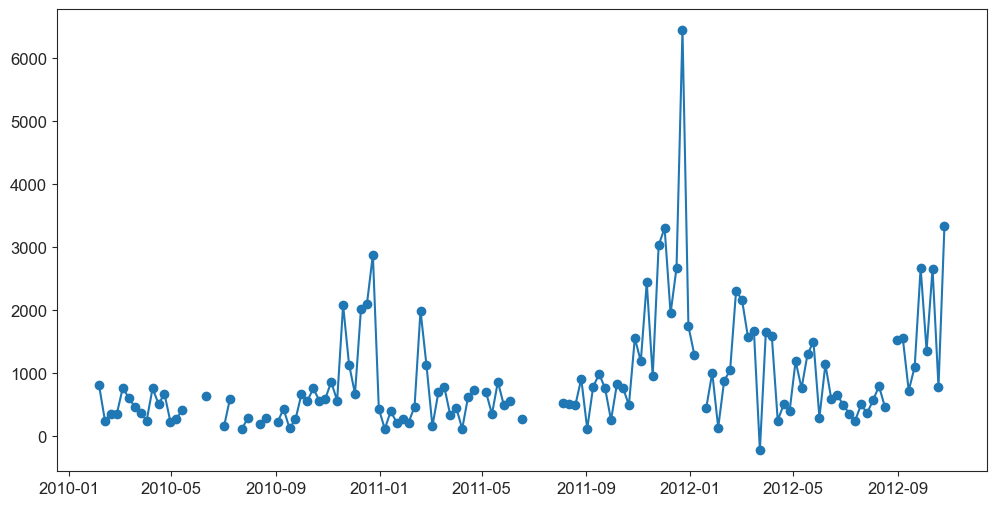

In [33]:
temp_copy = temp.copy()
#sns.lineplot(x='Date', y='Weekly_Sales', data=temp, marker='o')
plt.plot(temp['Date'], temp['Weekly_Sales'], marker='o')
plt.show()

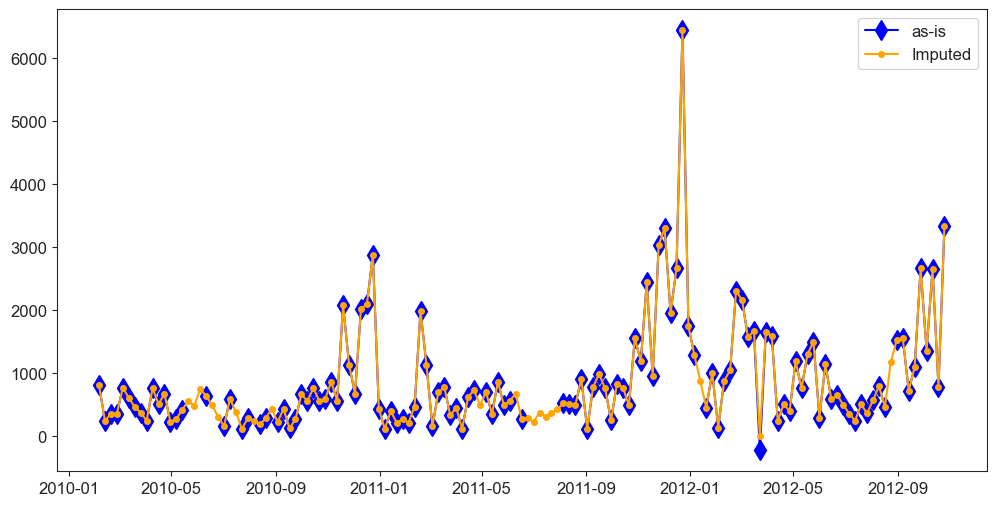

In [34]:
# fill missing values in the time series
imputed_indices = temp[temp['Weekly_Sales'].isna()].index
# apply STL decomposition to the time series
stl = STL(temp['Weekly_Sales'].interpolate(method='linear'), period=52)
res = stl.fit()
# extract the seasonal and trend components
seasonal, trend = res.seasonal, res.trend
# create the de-seasonalized and de-trended time series
residual = temp['Weekly_Sales'] - trend - seasonal
# interpolate the missing values in the residual series
residual_imp = residual.interpolate(method='linear')
# add the seasonal and trend components back to the imputed residual series
temp_imp = residual_imp + trend + seasonal
# make sure the imputed time series is non-negative
temp_imp[temp_imp < 0] = 0
# update the original time series with the imputed values
temp.loc[imputed_indices, 'Weekly_Sales'] = temp_imp[imputed_indices]
# plot the original and imputed time series
plt.plot(temp['Date'], temp_copy['Weekly_Sales'], marker='d', label='as-is', color='blue', markersize=10)
plt.plot(temp['Date'], temp_imp, marker='o', label='Imputed', color='orange', markersize=4)
plt.legend()
plt.show()

In [35]:
temp = df.loc[(df.Store==43)&(df.New_Dept==33), ['Date','Weekly_Sales']]
temp.isna().sum()

Date              0
Weekly_Sales    135
dtype: int64

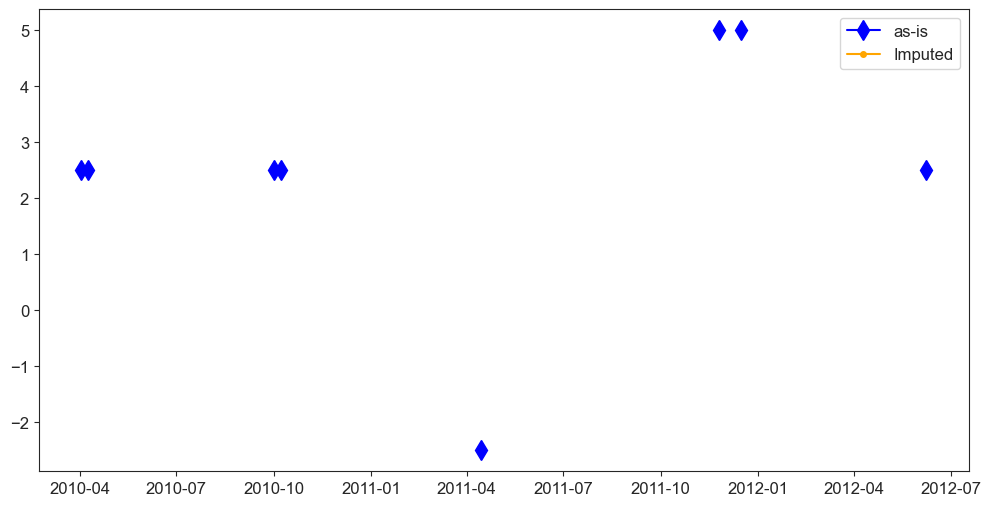

In [36]:
temp_copy = temp.copy()
#sns.lineplot(x='Date', y='Weekly_Sales', data=temp, marker='o')
# plt.plot(temp['Date'], temp['Weekly_Sales'], marker='o')
# plt.show()
# fill missing values in the time series
imputed_indices = temp[temp['Weekly_Sales'].isna()].index
# apply STL decomposition to the time series
stl = STL(temp['Weekly_Sales'].interpolate(method='linear'), period=52)
res = stl.fit()
# extract the seasonal and trend components
seasonal, trend = res.seasonal, res.trend
# create the de-seasonalized and de-trended time series
residual = temp['Weekly_Sales'] - trend - seasonal
# interpolate the missing values in the residual series
residual_imp = residual.interpolate(method='linear')
# add the seasonal and trend components back to the imputed residual series
temp_imp = residual_imp + trend + seasonal
# make sure the imputed time series is non-negative
temp_imp[temp_imp < 0] = 0
# update the original time series with the imputed values
temp.loc[imputed_indices, 'Weekly_Sales'] = temp_imp[imputed_indices]
# plot the original and imputed time series
plt.plot(temp['Date'], temp_copy['Weekly_Sales'], marker='d', label='as-is', color='blue', markersize=10)
plt.plot(temp['Date'], temp_imp, marker='o', label='Imputed', color='orange', markersize=4)
plt.legend()
plt.show()

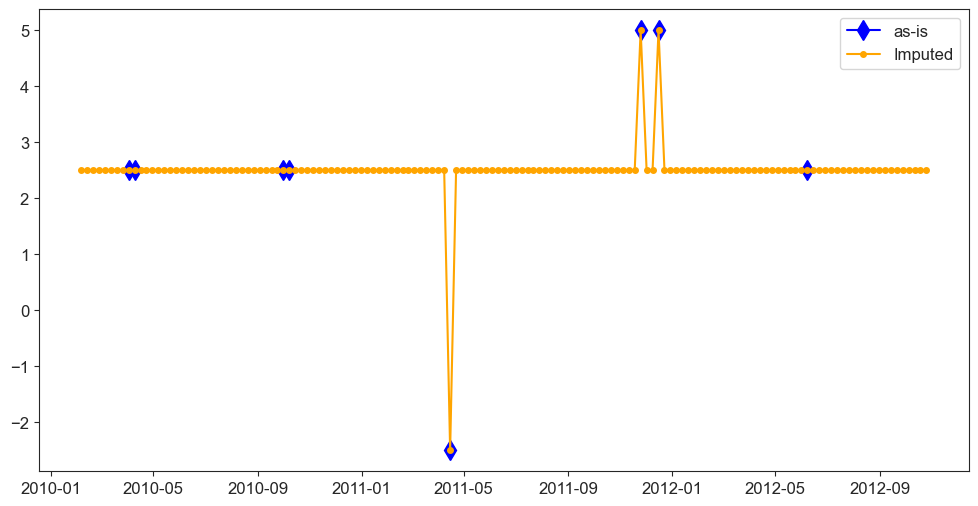

In [37]:
df_median = df.groupby(["Store","New_Dept"],observed=False)["Weekly_Sales"].median().reset_index()
df_median.columns = ["Store","New_Dept","Weekly_Sales_to_fill"]
a = df.merge(df_median, on=["Store","New_Dept"])
a.loc[df.Weekly_Sales.isna(),"Weekly_Sales"] = a.loc[df.Weekly_Sales.isna(),"Weekly_Sales_to_fill"]
temp_imp = a.loc[(df.Store==43)&(df.New_Dept==33), ['Date','Weekly_Sales']]
# plot the original and imputed time series
plt.plot(temp['Date'], temp_copy['Weekly_Sales'], marker='d', label='as-is', color='blue', markersize=10)
plt.plot(temp_imp['Date'], temp_imp['Weekly_Sales'], marker='o', label='Imputed', color='orange', markersize=4)
plt.legend()
plt.show()

If we need to perform the store-department scale analysis, we can pick the store-department pairs that are missing values free in the weekly sales column. For example, Store 19 Department 4 (paper goods) is a good candidate.
<div style="text-align: center;">
    <img src="dept4.png" alt="Holiday Dates">
</div>

In [74]:
df_s19d4 = df.loc[(df.Store==19)&(df.New_Dept==4)]
df_s19d4.isna().sum().sort_values(ascending=False).head()

Store           0
MarkDown2       0
Year            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

### 2.4.1 Reconstruct the joined dataframe df based on the store-category/subcategory and aggregate the weekly sales
- We will first try to aggregate the df by the store-subcategory pairs. We might try to work in the store-category scale later.
- We will then sum up the weekly sales for each store-subcategory pair.
- We will then drop columns ['New_Dept','Department Name', 'In Full Category'] since we no longer use them.
- We will then left join the df_merc with the stores table to get the store type and size information.
- We will then right join the df_merc with the features table to get all the features at all weeks during the time period for each store-department pair.
- We will then drop weeks greater than the max date in train1 data, since we don't have sales data for those weeks.
- We will then convert the ['Store', 'Merch Align'] column to categorical types.
- We will then extract the year and week from the ['Date'] column to create new columns ['Year', 'Week'].
- We will then fill the missing values in the markdown1-5 columns with 0.
- At last, we end up with a NA-free dataframe df_merc, which is a 51,480 entries by 16 columns. 51,480 = 45 stores * 8 sub-categories * 143 weeks.

In [38]:
df['Merch Align'].value_counts(dropna=False)

Merch Align
Apparel                              92235
Food                                 83083
Hardlines                            59202
Entertainment, Toys, and Seasonal    51480
Home                                 44759
Consumables                          38610
Service                              21164
Health and Wellness                  12870
Name: count, dtype: int64

In [39]:
df['In Full Category'].value_counts(dropna=False)

In Full Category
General Merchandise    241241
Food                    83083
Consumables             45045
Service                 21164
Health and Wellness     12870
Name: count, dtype: int64

In [40]:
45*8*143

51480

In [59]:
# Aggregate the df by the store-subcategory pairs
df_merc = df.loc[:, ].groupby(['Store','Merch Align','Date'], observed=True).agg({'Weekly_Sales':'sum'}).reset_index()
# left join df_merc with stores to get the store type and size information
df_merc = df_merc.merge(stores, on='Store', how='left')
# right join df_merc with features to get all the features at all weeks during the time period for each store-department pair
features['Date'] = pd.to_datetime(features['Date'])
df_merc = df_merc.merge(features, on = ["Store", 'Date'], how="right")
# drop weeks greater than max date in train1 data, since we don't have sales data for those weeks
df_merc = df_merc[df_merc["Date"]<=max_date].reset_index(drop=True)
# Convert the ['Store', 'Merch Align'] column to categorical types
df_merc['Store'] = df_merc['Store'].astype('category')
df_merc['Merch Align'] = df_merc['Merch Align'].astype('category')
# Extract the year and week from the ['Date'] column to create new columns ['Year', 'Week']
df_merc['Year'] = df_merc['Date'].dt.year
df_merc['Week'] = df_merc['Date'].dt.isocalendar().week
# fill the missing values in the markdown1-5 columns with 0
df_merc[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = df_merc[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)


In [60]:
# No NAs in weekly sales due to the aggregation by sub-category
df_merc.isna().sum().sort_values(ascending=False).head()# use the Tukey's fense method to detect the outliers in the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns
k = 2
def tukey_fences(x, k):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (x < (q1 - k * iqr)) | (x > (q3 + k * iqr))
a = tukey_fences(x_num_bc['bc_availableMoney'],k=k).sum()
b = tukey_fences(x_num_bc['bc_transactionAmount'],k=k).sum()
c = tukey_fences(x_num_bc['bc_currentBalance'],k=k).sum()

Store           0
Merch Align     0
Year            0
IsHoliday       0
Unemployment    0
dtype: int64

## 2.5 Outlier detection on both df_s19d1 (store-department) and df_merc (store-subcategory) dataframes.

- Outliers should be screened out from the same store-department pair or store-subcategory pair, since the sales pattern and trend of the same store-department pair or store-subcategory pair can be quite different from the sales pattern and trend of the same department in different stores or the same subcategory in different stores.
- Given the fact that holiday weeks are highly valued and tend to behave in a totally different model than non-holiday weeks, we will perform outlier detection on non-holiday weeks ONLY and keep all the holiday weeks as-is.
- Eye-balling and the Tukey's fences method will be used to detect the outliers. 

### 2.5.1 Outlier detection on df_s19d1 (store-department) dataframes

In [71]:
# define the Tukey's fense method to detect the outliers 
k = 1.5
def tukey_fences(x, k=1.5):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (x < (q1 - k * iqr)) | (x > (q3 + k * iqr))

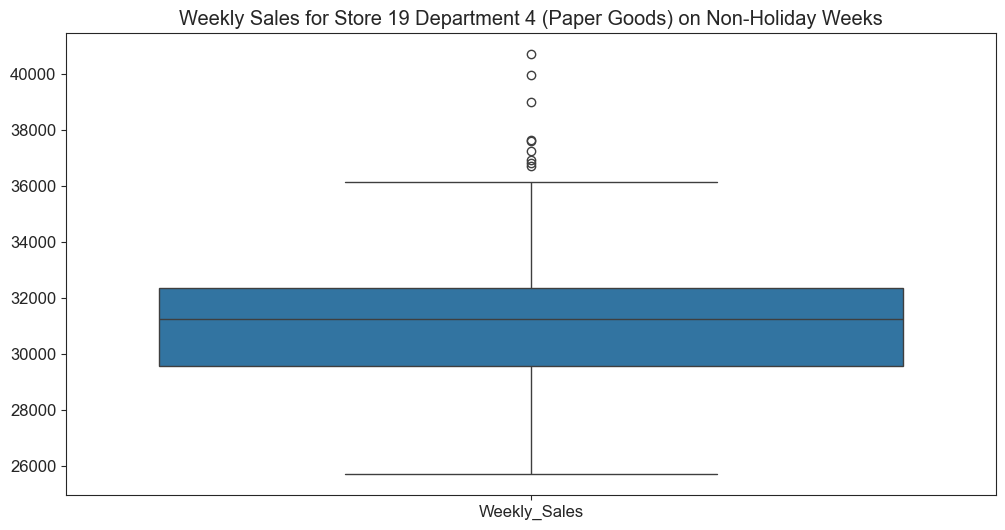

In [105]:
# Outlier detection on df_s19d1
ws_s19d4_nh = df_s19d4.loc[df_s19d4.IsHoliday==False, ['Date','Weekly_Sales']]
# use sns to plot the boxplot
sns.boxplot(ws_s19d4_nh)
plt.title('Weekly Sales for Store 19 Department 4 (Paper Goods) on Non-Holiday Weeks')
plt.show()

In [106]:
# find the index of the outliers in the df_s19d4
s19d4_nh_outer_index = tukey_fences(ws_s19d4_nh['Weekly_Sales'])
s19d4_nh_outer = ws_s19d4_nh[s19d4_nh_outer_index]

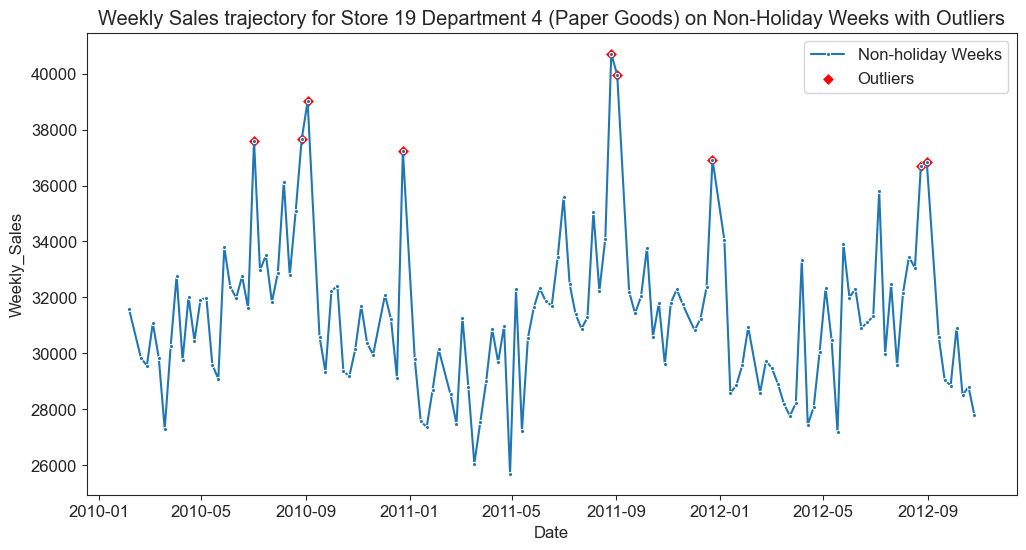

In [107]:
# lineplot the outliers in the df_s19d4
sns.lineplot(x='Date', y='Weekly_Sales', data=ws_s19d4_nh, marker='.', label='Non-holiday Weeks')
# mark the outliers in the scatterplot
sns.scatterplot(x='Date', y='Weekly_Sales', data=s19d4_nh_outer, marker='D', label='Outliers', color='r', sizes=10)
plt.title('Weekly Sales trajectory for Store 19 Department 4 (Paper Goods) on Non-Holiday Weeks with Outliers')
plt.show()

Now, impute the outliers in the df_s19d4 dataframe with the rolling mean of the past 4 non-holiday weekly sales of the same store-department pair in the same week of the year.

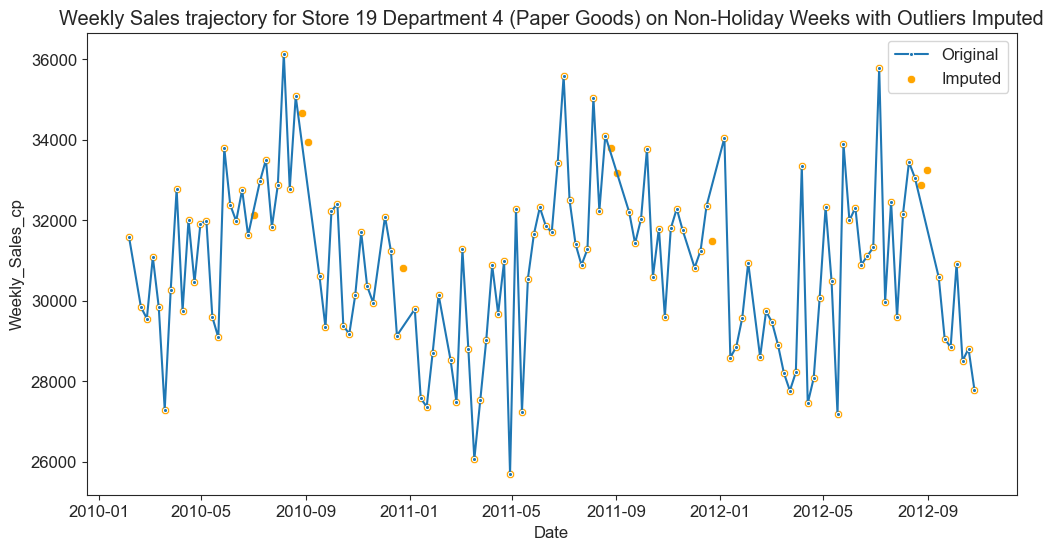

In [111]:
# set the weekly_sales of the outliers in the ws_s19d4_nh to np.nan
ws_s19d4_nh['Weekly_Sales_cp'] = ws_s19d4_nh['Weekly_Sales']
ws_s19d4_nh.loc[s19d4_nh_outer_index, 'Weekly_Sales'] = np.nan
# Use rolling mean to impute the outliers in the ws_s19d4_nh
ws_s19d4_nh['Weekly_Sales_outerFill'] = ws_s19d4_nh['Weekly_Sales'].fillna(ws_s19d4_nh['Weekly_Sales'].rolling(4, min_periods=1).mean())
# lineplot the original and imputed time series
sns.lineplot(x='Date', y='Weekly_Sales_cp', data=ws_s19d4_nh, marker='.', label='Original')
sns.scatterplot(x='Date', y='Weekly_Sales_outerFill', data=ws_s19d4_nh, marker='o', label='Imputed', c='orange')
plt.title('Weekly Sales trajectory for Store 19 Department 4 (Paper Goods) on Non-Holiday Weeks with Outliers Imputed')
plt.show()

In [112]:
# update the original df_s19d4 with the imputed values
df_s19d4.loc[df_s19d4.IsHoliday==False, 'Weekly_Sales'] = ws_s19d4_nh['Weekly_Sales_outerFill']

### 2.5.2 Outlier detection on df_merc (store-subcategory) dataframes

In [ ]:
# Outlier detection on df_merc by store-subcategory pairs by a for-loop




In [100]:
sdw.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .set_caption("Stats Summary of Numeric Variables")\
                            .background_gradient(subset=['min'], cmap='Reds')\
                            .background_gradient(subset=['max'], cmap='Greens')\
                            .background_gradient(subset=['std'], cmap='GnBu')\
                            .background_gradient(subset=['50%'], cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
Store,476333.000000,22.497448,12.831751,1.000000,11.000000,22.000000,33.000000,45.000000
Size,476333.000000,133950.658361,61889.885131,34875.000000,93188.000000,128107.000000,202505.000000,219622.000000
Dept,476333.000000,45.715101,30.141421,1.000000,20.000000,41.000000,74.000000,99.000000
Temperature,476333.000000,60.333886,18.452828,-2.060000,47.070000,62.360000,74.600000,100.140000
Fuel_Price,476333.000000,3.359182,0.458859,2.472000,2.932000,3.452000,3.737000,4.468000
MarkDown1,168943.000000,7090.052321,8238.921862,0.270000,2034.630000,5197.640000,9082.610000,88646.760000
MarkDown2,123431.000000,3278.825551,9366.852656,-265.760000,40.000000,190.980000,1891.530000,104519.540000
MarkDown3,152700.000000,1390.253102,9435.843266,-29.100000,4.930000,23.900000,101.860000,141630.610000
MarkDown4,149148.000000,3345.447838,6247.805509,0.220000,499.880000,1455.150000,3557.170000,67474.850000
MarkDown5,169881.000000,4542.875820,5905.099809,135.160000,1797.840000,3281.610000,5507.250000,108519.280000


In [ ]:
besides total markdown, add a boolean column to indicate whether markdown is available that week for this store. 